In [12]:
# Initialise a spark session
import pandas as pd
from collections import Counter
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


spark = (
    SparkSession.builder.appName("Fraud Detection")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Increase driver memory
    .config("spark.executor.memory", "8g")  # Increase executor memory
    .config("spark.executor.instances", "4")  # Increase the number of executor instances
    .config("spark.driver.maxResultSize", "2g")
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
)

ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:
# Read transaction file
transactions = spark.read.parquet('../data/curated/flagged_fraud/*.parquet')

In [ ]:
transactions.printSchema()

transactions.show(5)

root
 |-- merchant_abn: long (nullable = true)
 |-- year_week: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- fraud_probability_consumer: double (nullable = true)
 |-- name_consumer: string (nullable = true)
 |-- address_consumer: string (nullable = true)
 |-- state_consumer: string (nullable = true)
 |-- postcode_consumer: integer (nullable = true)
 |-- gender_consumer: string (nullable = true)
 |-- name_merchant: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- fraud_probability_merchant: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- order_month_year: string (nullable = true)
 |-- SA4_CODE_2011: string (nullable = true)
 |-- SA4_NAME_2011: string (nullable = true)
 |-- unemployment_rate: string (nullable = true)
 |-- z_score: double (nullable = true)
 |-- consumer_weekly_transaction: long (nullabl

+------------+---------+-------+------------------+--------------------+-----------+--------------------------+-----------------+--------------------+--------------+-----------------+---------------+-------------+--------------------+--------------------------+--------------+----------------+-------------+--------------------+-----------------+--------------------+---------------------------+---------------------------+--------+
|merchant_abn|year_week|user_id|      dollar_value|            order_id|consumer_id|fraud_probability_consumer|    name_consumer|    address_consumer|state_consumer|postcode_consumer|gender_consumer|name_merchant|                tags|fraud_probability_merchant|order_datetime|order_month_year|SA4_CODE_2011|       SA4_NAME_2011|unemployment_rate|             z_score|consumer_weekly_transaction|merchant_weekly_transaction|is_fraud|
+------------+---------+-------+------------------+--------------------+-----------+--------------------------+-----------------+-----

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = transactions.select(
    "merchant_abn", "dollar_value", "fraud_probability_consumer", 
    "fraud_probability_merchant", "consumer_weekly_transaction", 
    "merchant_weekly_transaction", "z_score", "postcode_consumer", 
    "unemployment_rate", "is_fraud"
).toPandas()

print("Basic Statistics:")
print(pandas_df.describe(include="all"))

print("\nMissing Values Count:")
print(pandas_df.isnull().sum())

24/09/25 00:36:54 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Basic Statistics:
        merchant_abn  dollar_value  fraud_probability_consumer  \
count   1.611599e+07  1.611599e+07                1.611599e+07   
unique           NaN           NaN                         NaN   
top              NaN           NaN                         NaN   
freq             NaN           NaN                         NaN   
mean    5.540170e+10  1.342180e+02                1.364578e+01   
std     2.532216e+10  2.052414e+02                8.600280e+00   
min     1.002328e+10  9.756658e-08                8.287144e+00   
25%     3.284414e+10  2.587279e+01                9.296537e+00   
50%     5.512328e+10  6.128814e+01                1.129867e+01   
75%     7.731308e+10  1.461675e+02                1.377254e+01   
max     9.999054e+10  1.721284e+03                9.924738e+01   

        fraud_probability_merchant  consumer_weekly_transaction  \
count                 1.611599e+07                 1.611599e+07   
unique                         NaN                     

### checking the unqiue values in the 'is_fraud' column

In [ ]:
unique_values = pandas_df['is_fraud'].unique()
print("Unique values in 'is_fraud':", unique_values)

Unique values in 'is_fraud': [False  True]


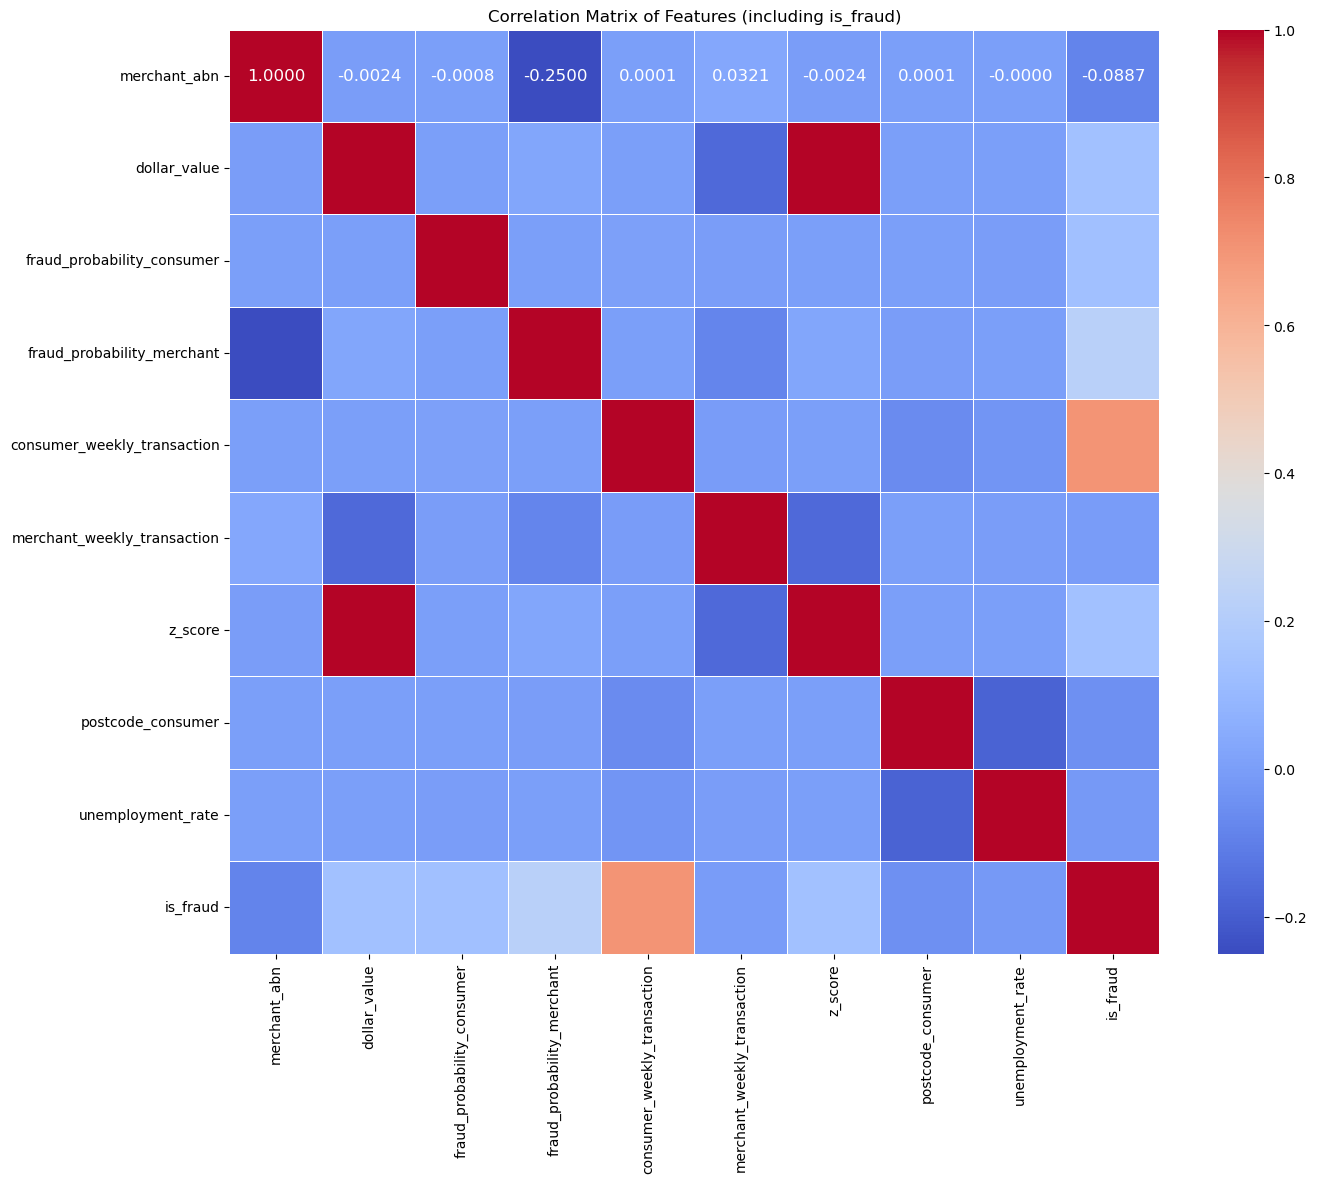

Correlation with 'is_fraud':
is_fraud                       1.000000
consumer_weekly_transaction    0.705600
fraud_probability_merchant     0.219207
dollar_value                   0.136579
z_score                        0.136579
fraud_probability_consumer     0.132166
merchant_weekly_transaction   -0.006004
unemployment_rate             -0.017846
postcode_consumer             -0.048817
merchant_abn                  -0.088656
Name: is_fraud, dtype: float64


In [ ]:
pandas_df['unemployment_rate'] = pd.to_numeric(pandas_df['unemployment_rate'], errors='coerce')

numeric_columns = pandas_df.select_dtypes(include='number')

corr_matrix = pandas_df.corr()
#print(corr_matrix)
plt.figure(figsize=(15, 12))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.4f', linewidths=0.5, annot_kws={"size": 12})
plt.title('Correlation Matrix of Features (including is_fraud)')
plt.show()
correlation_with_target = pandas_df.corr()['is_fraud'].sort_values(ascending=False)

print("Correlation with 'is_fraud':")
print(correlation_with_target)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = pandas_df[["consumer_weekly_transaction", "fraud_probability_merchant", "dollar_value"]]
y = pandas_df["is_fraud"]

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_dev_scaled = scaler.transform(X_dev)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_dev_scaled)

print("Logistic Regression Accuracy:", metrics.accuracy_score(y_dev, y_pred_lr))
print("Confusion Matrix for Logistic Regression:\n", metrics.confusion_matrix(y_dev, y_pred_lr))
print("Classification Report for Logistic Regression:\n", metrics.classification_report(y_dev, y_pred_lr))

y_pred_proba_lr = lr_model.predict_proba(X_dev_scaled)[:, 1]
roc_auc_lr = metrics.roc_auc_score(y_dev, y_pred_proba_lr)
print("ROC AUC Score for Logistic Regression:", roc_auc_lr)

Logistic Regression Accuracy: 0.9167880160804209
Confusion Matrix for Logistic Regression:
 [[2803867  181190]
 [ 154071  889871]]
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

       False       0.95      0.94      0.94   2985057
        True       0.83      0.85      0.84   1043942

    accuracy                           0.92   4028999
   macro avg       0.89      0.90      0.89   4028999
weighted avg       0.92      0.92      0.92   4028999

ROC AUC Score for Logistic Regression: 0.9461504270070952


In [ ]:
y_pred_proba_lr = lr_model.predict_proba(X_dev_scaled)[:, 1]

X_dev['merchant_abn'] = pandas_df['merchant_abn'].iloc[X_dev.index]
X_dev['fraud_probability_lr'] = y_pred_proba_lr

top_merchants_aggregated = X_dev.groupby('merchant_abn')['fraud_probability_lr'].min().reset_index()
top_100_merchants_lr = top_merchants_aggregated.sort_values(by="fraud_probability_lr", ascending=True).head(100)

print("Top 100 merchants predicted by Logistic Regression:")
print(top_100_merchants_lr)

top_100_merchants_lr.to_csv('top_100_merchants_lr.csv', index=False)

Top 100 merchants predicted by Logistic Regression:
      merchant_abn  fraud_probability_lr
515    21439773999              0.019031
1795   48534649627              0.019823
1373   39649557865              0.019981
499    21025433654              0.020246
496    20985347699              0.020255
...            ...                   ...
1538   43061683632              0.021173
2345   60978195146              0.021173
2660   67794222692              0.021176
407    19054547079              0.021178
2489   64127544910              0.021178

[100 rows x 2 columns]


24/09/25 01:56:43 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 306305 ms exceeds timeout 120000 ms
24/09/25 01:56:43 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/25 01:56:45 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o